In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

import ema_workbench
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging)
from ema_workbench.analysis import prim


# Old experiments

## 1. Loading the scenario dataset

In [14]:
#loading the results from a specific set of experiments
sufficientarian_threshold = 50
path = f"old_experiments\ZAs_below_{sufficientarian_threshold}  - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv"
full_df = pd.read_csv(path)
full_df.head(2)

,Unnamed: 0,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,chapala_flow,calderon_flow,zapotillo_flow,pozos_flow,toluquilla_flow,...,supply_percapita_PP3,supply_percapita_Toluquilla,supply_percapita_Pozos,min_supplied_demand,supplied_demand_GINI,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario.1,experiment
0,0,0.085523,0.331658,0.596318,-0.518173,4.252350,0.960307,0.329354,0.304787,0.861636,...,107.0,72.0,107.0,0.36032,0.129174,5.0,2.0,0.0,113504.0,ZAs_below_50 - 1000 scenarios - 1000nfe epsil...
1,1,0.062368,-0.562929,-0.030044,-0.042071,2.127411,0.575665,0.865325,1.394283,0.346133,...,117.0,54.0,87.0,0.32637,0.189322,5.0,3.0,0.0,172599.0,ZAs_below_50 - 1000 scenarios - 1000nfe epsil...


In [15]:
sufficientarian_threshold = 1000
print(path)

old_experiments\ZAs_below_50  - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv


In [16]:


#Defining what optimizations will be explored
sufficientarian_threshold = 100

#loading the results from a specific set of experiments
full_df = pd.read_csv(path)

#loading the results from the 50l/day/person 1000 scenarios with restriction optimization
prim_df = full_df
#prim_df = pd.read_csv("experiment_results\ZAs_below_50  - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv", index_col = [0])

#Create a new column with False for the scenarios where there's no solution that can ensure that all ZA are above the sufficientarian threshold
variable_of_interest = f"ZAs_below_{sufficientarian_threshold}"
prim_df["scenario_of_interest"] = prim_df[variable_of_interest] == 0

all_columns = prim_df.columns
print(all_columns)

Index(['Unnamed: 0', 'aqp4_Toluquilla_to_PP1', 'aqp1_PP2_to_PP3',
       'aqp2_PP3_to_Pozos', 'aqp3_Pozos_to_Toluquilla', 'chapala_flow',
       'calderon_flow', 'zapotillo_flow', 'pozos_flow', 'toluquilla_flow',
       'scenario', 'delivered_PP1', 'delivered_PP2', 'delivered_PP3',
       'delivered_Toluquilla', 'delivered_Pozos', 'supplied_PP1',
       'supplied_PP2', 'supplied_PP3', 'supplied_Toluquilla', 'supplied_Pozos',
       'total_supplied', 'demand_PP1', 'demand_PP2', 'demand_PP3',
       'demand_Toluquilla', 'demand_Pozos', 'supplied_demand_PP1',
       'supplied_demand_PP2', 'supplied_demand_PP3',
       'supplied_demand_Toluquilla', 'supplied_demand_Pozos',
       'supplied_demand_deficit_PP1', 'supplied_demand_deficit_PP2',
       'supplied_demand_deficit_PP3', 'supplied_demand_deficit_Toluquilla',
       'supplied_demand_deficit_Pozos', 'supply_percapita_PP1',
       'supply_percapita_PP2', 'supply_percapita_PP3',
       'supply_percapita_Toluquilla', 'supply_percapita_Po

## 2. Developing the Indicator

### 2.1 Logistic Regresion for each threshold


In [17]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

log_reg_results = {}
dataframes = {}



for threshold in [50, 100, 128]:
    full_df = pd.read_csv(f"old_experiments\ZAs_below_{threshold}  - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")
    #loading the results from the 50l/day/person 1000 scenarios with restriction optimization
    log_reg_df = full_df

    #Create a new column with False for the scenarios where there's no solution that can ensure that all ZA are above the sufficientarian threshold
    variable_of_interest = f"ZAs_below_{threshold}"
    log_reg_df["scenario_of_interest"] = log_reg_df[variable_of_interest] > 0

    log_reg_df=log_reg_df.loc[:][['chapala_flow', 'calderon_flow',
        'pozos_flow', 'toluquilla_flow',"zapotillo_flow","scenario_of_interest"]]
    
    dataframes = {threshold:log_reg_df}

    log_reg_df["intercept"] = np.ones(np.shape(log_reg_df)[0])
    predictors = ['chapala_flow', 'calderon_flow', 'pozos_flow',"zapotillo_flow", 'toluquilla_flow', 'intercept']

    logit = sm.Logit(log_reg_df["scenario_of_interest"], log_reg_df[predictors])
    log_reg_results[threshold] = logit.fit()


def predict_scenario(scenario,threshold):
    # Add an intercept term
    scenario['intercept'] = 1

    # Predict the probability of the scenario being of interest
    scenario_array = np.array([scenario[col] for col in predictors])
    log_odds = np.dot(log_reg_results[threshold].params, scenario_array)
    probability = 1 / (1 + np.exp(-log_odds))
    
    return probability





Optimization terminated successfully.
         Current function value: 0.034219
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.146963
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.052838
         Iterations 12


In [18]:
print(log_reg_results[128].summary2())

                            Results: Logit
Model:              Logit                Method:           MLE        
Dependent Variable: scenario_of_interest Pseudo R-squared: 0.860      
Date:               2024-06-13 16:38     AIC:              117.6760   
No. Observations:   1000                 BIC:              147.1225   
Df Model:           5                    Log-Likelihood:   -52.838    
Df Residuals:       994                  LL-Null:          -378.71    
Converged:          1.0000               LLR p-value:      1.3270e-138
No. Iterations:     12.0000              Scale:            1.0000     
-----------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------------
chapala_flow       -6.2367    0.8889  -7.0162  0.0000  -7.9789  -4.4945
calderon_flow      -4.2489    0.8680  -4.8947  0.0000  -5.9502  -2.5475
pozos_flow         -6.6040   

### 2.2 Testing the logistic regression

In [22]:

new_scenario = {
    'chapala_flow': 6.9,
    'calderon_flow': 1,
    'pozos_flow': 2.3,
    'toluquilla_flow': 0.5,
    "zapotillo_flow" : 0
}

probability_threshold = 0.5
sufficientarian_thresholds = [50, 100, 128]

for threshold in sufficientarian_thresholds:
    likelihood = predict_scenario(new_scenario, threshold) 

    print(f"The likelihood that at least one ZA will fall below {threshold}l/day/person under this scenario is : {likelihood:.2f}")

for threshold in sufficientarian_thresholds:
    likelihood = predict_scenario(new_scenario, threshold)
    
    if likelihood>= probability_threshold:
        if threshold == 50: 
            print("Thus, the current drought state is considered HIGH")
            break
        elif threshold == 100: 
            print("Thus, the current drought state is considered  MID drought")
            break
        elif threshold == 128:
            print("Thus, the current drought state is considered LOW")
            break
    if threshold == 128: print("Thus, the current drought state is considered NO drought")
        

ValueError: shapes (6,) and (4,) not aligned: 6 (dim 0) != 4 (dim 0)

C:\Users\ariel\AppData\Local\Temp\ipykernel_27860\1306569203.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  contour_cmap = mpl.cm.get_cmap('RdBu')


Optimization terminated successfully.
         Current function value: 0.019048
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.129038
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035116
         Iterations 13


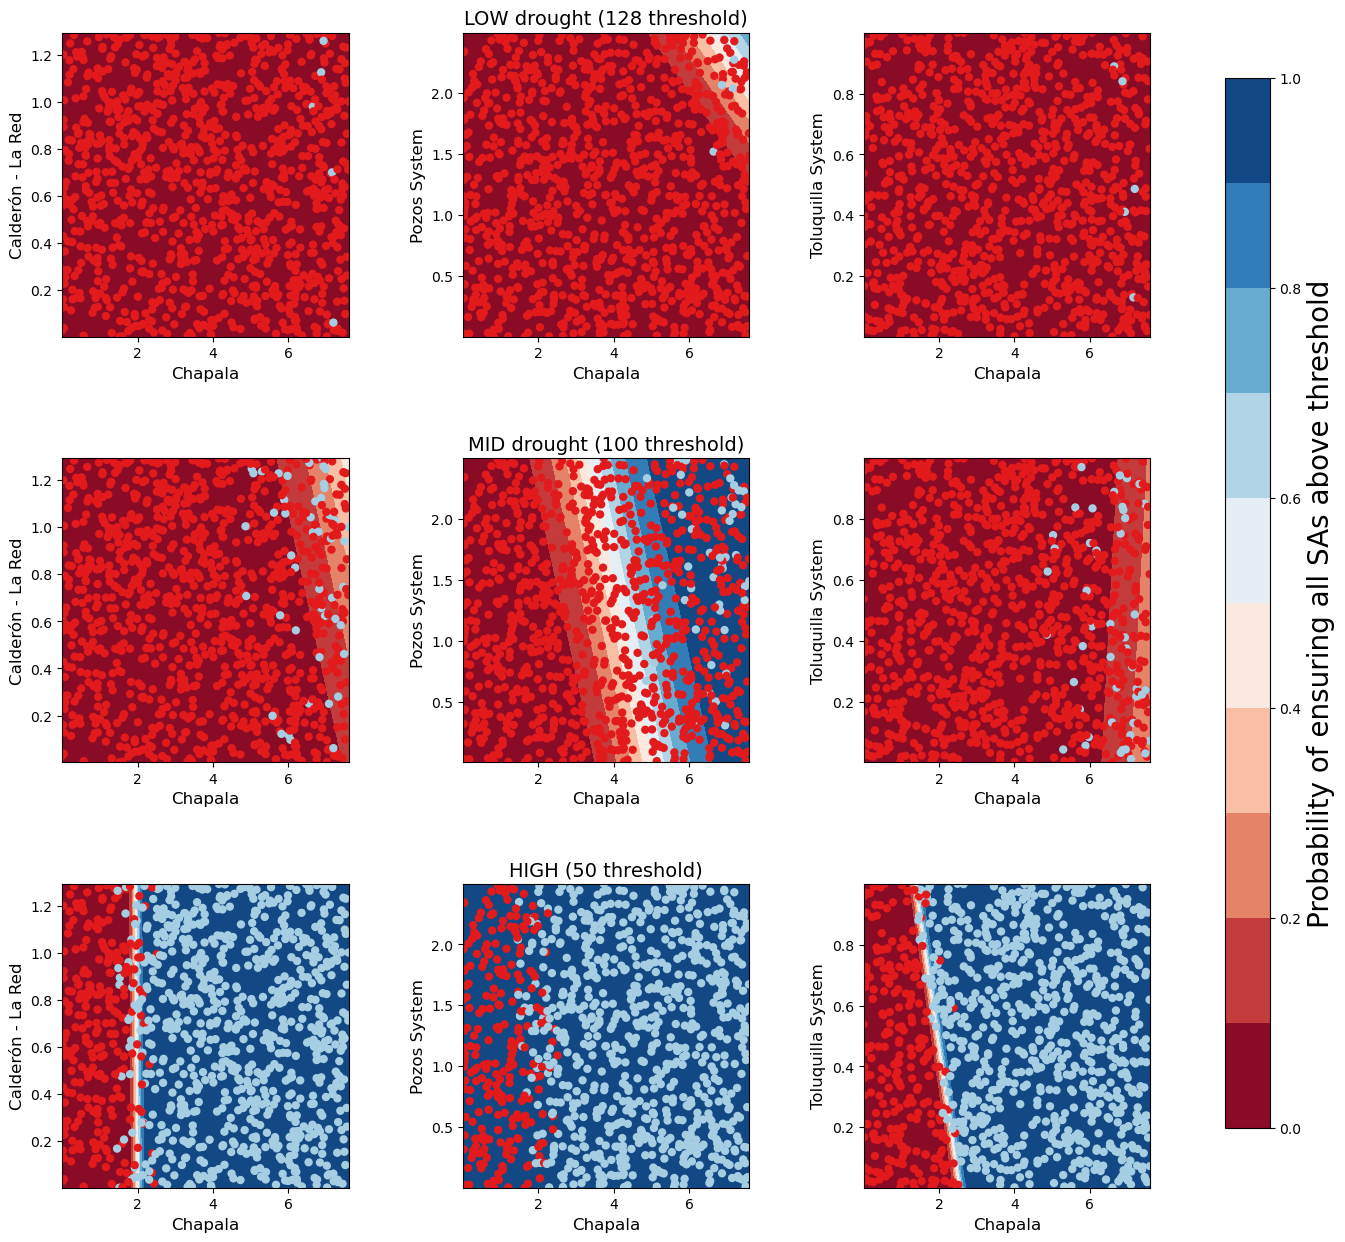

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

def load_and_prepare_data(threshold):
    full_df = pd.read_csv(path)
    log_reg_df = full_df.loc[full_df["chapala_flow"] < 8][:]
    variable_of_interest = f"ZAs_below_{threshold}"
    log_reg_df["scenario_of_interest"] = log_reg_df[variable_of_interest] == 0
    predictors = ["chapala_flow", 'calderon_flow', 'pozos_flow', 'toluquilla_flow']
    target = 'scenario_of_interest'
    dta = log_reg_df[predictors + [target]]
    return dta, predictors, target

def fitLogit(dta, predictors):
    dta['Intercept'] = np.ones(np.shape(dta)[0])
    cols = ['Intercept'] + predictors
    logit = sm.Logit(dta['scenario_of_interest'], dta[cols])
    result = logit.fit()
    return result

def plotContourMap(ax, result, constant, dta, contour_cmap, dot_cmap, levels, xgrid, ygrid, xvar, yvar, base):
    X, Y = np.meshgrid(xgrid, ygrid)
    x = X.flatten()
    y = Y.flatten()

    if constant == 'pozos_flow':  # pozos_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, y, np.ones(len(x)) * base[2], np.ones(len(x)) * base[3]])
    elif constant == 'calderon_flow':  # calderon_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, np.ones(len(x)) * base[1], y, np.ones(len(x)) * base[3]])
    elif constant == 'toluquilla_flow':  # toluquilla_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, np.ones(len(x)) * base[1], np.ones(len(x)) * base[2], y])
    else:  # chapala_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), np.ones(len(x)) * base[0], x, y, np.ones(len(x)) * base[3]])

    z = result.predict(grid)
    Z = np.reshape(z, np.shape(X))

    contourset = ax.contourf(X, Y, Z, levels, cmap=contour_cmap)
    ax.scatter(dta[xvar].values, dta[yvar].values, c=dta['scenario_of_interest'].values, edgecolor='none', cmap=dot_cmap)
    ax.set_xlim(np.min(X), np.max(X))
    ax.set_ylim(np.min(Y), np.max(Y))
    ax.set_xlabel(xvar, fontsize=12)
    ax.set_ylabel(yvar, fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

    # Rename the axes
    ax.set_xlabel('Chapala', fontsize=12)
    if yvar == 'calderon_flow':
        ax.set_ylabel('Calderón - La Red', fontsize=12)
    elif yvar == 'pozos_flow':
        ax.set_ylabel('Pozos System', fontsize=12)
    elif yvar == 'toluquilla_flow':
        ax.set_ylabel('Toluquilla System', fontsize=12)

    return contourset

# Define color maps and levels
dot_cmap = mpl.colors.ListedColormap(np.array([[227, 26, 28], [166, 206, 227]]) / 255.0)
contour_cmap = mpl.cm.get_cmap('RdBu')
contour_levels = np.arange(0.0, 1.05, 0.1)

# Initialize the figure
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

thresholds = [128, 100, 50]
titles = ['LOW drought (128 threshold)', 'MID drought (100 threshold)', 'HIGH (50 threshold)']

for i, threshold in enumerate(thresholds):
    dta, predictors, target = load_and_prepare_data(threshold)
    result = fitLogit(dta, predictors)
    
    xgrid = np.linspace(dta[predictors[0]].min(), dta[predictors[0]].max(), 100)
    ygrid = np.linspace(dta[predictors[1]].min(), dta[predictors[1]].max(), 100)
    zgrid = np.linspace(dta[predictors[2]].min(), dta[predictors[2]].max(), 100)
    tgrid = np.linspace(dta[predictors[3]].min(), dta[predictors[3]].max(), 100)
    base = [dta[predictors[0]].mean(), dta[predictors[1]].mean(), dta[predictors[2]].mean(), dta[predictors[3]].mean()]

    plotContourMap(axes[i, 0], result, 'pozos_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, ygrid, predictors[0], predictors[1], base)
    plotContourMap(axes[i, 1], result, 'calderon_lared_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, zgrid, predictors[0], predictors[2], base)
    contourset = plotContourMap(axes[i, 2], result, 'toluquilla_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, tgrid, predictors[0], predictors[3], base)

    axes[i, 1].set_title(titles[i], fontsize=14)

# Adjust subplot spacing and add a single colorbar for the entire figure
fig.subplots_adjust(wspace=0.4, hspace=0.4, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(contourset, cax=cbar_ax, cmap=contour_cmap)
cbar_ax.set_ylabel('Probability of ensuring all SAs above threshold', fontsize=20)

plt.show()


### 2.3 Making the Indicator Funciton

In [21]:
def calculate_urban_drought_indicator(drought_state={'chapala_flow': 6.9,'calderon_flow': 1,'pozos_flow': 2.3,'toluquilla_flow': 0.5},
                                                     probability_threshold = 0.5,
                                                     sufficientarian_thresholds = [50, 100, 128]):

    for threshold in sufficientarian_thresholds:
        likelihood = predict_scenario(drought_state, threshold)
        
        if likelihood>= probability_threshold:
            if threshold == sufficientarian_thresholds[0]: 
                drought_conditions = "HIGH"
                break
            elif threshold == sufficientarian_thresholds[1]: 
                drought_conditions = "MID"
                break
            elif threshold == sufficientarian_thresholds[2]:
                drought_conditions = "LOW"
                break
        if threshold == sufficientarian_thresholds[2]: drought_conditions = "NO"
    
    return drought_conditions, round(likelihood,2)
    

drought_index = calculate_urban_drought_indicator(new_scenario)

ValueError: shapes (6,) and (4,) not aligned: 6 (dim 0) != 4 (dim 0)

In [ ]:
drought_index = calculate_urban_drought_indicator(drought_state=new_scenario
)

print(drought_index)

('LOW', 0.76)


### 2.4 Validating the Indicator

To validate the indicator we will estimate the drought contitions for each drought state of the results of the three optimizations. By comparing the amount of ZAs under the threshold of the current optimization to the drought conditions estimated by the indicator we can assess how precise is the indicator. The results of each optimization are only usefull to assess the precision of their correspondant drought condition. For example, if we want to assess the capacity of the indicator to label HIGH drought conditions we will check how often it estimated that drought conditions are high for the cases where the optimization algorithm found 1 or more ZAs under 50l/day/person.

In [ ]:
scarcity_indicator_validation_df = pd.DataFrame()

for indicator in ["ZAs_below_50", "ZAs_below_100", "ZAs_below_128"]:

    validation_df = pd.read_csv(f"experiment_results\{indicator} - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")
    validation_df = validation_df.loc[:][['chapala_flow', 'calderon_flow', 'pozos_flow', 'toluquilla_flow', 'ZAs_below_50',"ZAs_below_100", "ZAs_below_128"]]
    validation_df["drought_state"] = ""
    validation_df["probability"] = ""
    for index, row in validation_df.iterrows():


        drought_state = row[['chapala_flow', 'calderon_flow', 'pozos_flow', 'toluquilla_flow']].to_dict()
        probability_threshold = 0.5
        sufficientarian_thresholds = [50, 100, 128]

        drought_indicator = calculate_urban_drought_indicator(drought_state=drought_state, probability_threshold=probability_threshold, sufficientarian_thresholds=sufficientarian_thresholds)
        
        drought_state = drought_indicator[0]
        likelihood = drought_indicator[1]

        validation_df["probability"][index] = likelihood
        validation_df["drought_state"][index]=drought_state
        validation_df["optimization"] = indicator




    scarcity_indicator_validation_df = pd.concat([scarcity_indicator_validation_df, validation_df], axis = 0)

scarcity_indicator_validation_df.to_csv("results/scarcity_validation_df.csv")



C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\2240702807.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["probability"][index] = likelihood
C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\2240702807.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["drought_state"][index]=drought_state


In [ ]:
scarcity_indicator_validation_df.head()

,chapala_flow,calderon_lared_flow,pozos_flow,toluquilla_flow,ZAs_below_50,ZAs_below_100,ZAs_below_142,drought_state,probability,optimization
0,9.073719,3.849682,4.058541,0.156112,0.0,1.0,1.0,NO,0.0,ZAs_below_50
1,8.654988,1.304894,2.469831,0.078252,0.0,0.0,1.0,NO,0.15,ZAs_below_50
2,8.433053,0.223405,4.303270,0.419695,0.0,1.0,1.0,NO,0.04,ZAs_below_50
3,8.382582,0.605412,1.098129,0.060575,0.0,1.0,2.0,LOW,0.72,ZAs_below_50
4,5.756758,1.478194,3.580713,0.544802,0.0,0.0,1.0,LOW,0.78,ZAs_below_50


In [ ]:
import pandas as pd

# Assuming the `scarcity_indicator_validation_df` has been created and populated

def calculate_summary(df):
    summary = {
        'HIGH drought': {
            'True positive': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] > 0) & (df['drought_state'] == 'HIGH')).sum(),
            'True negative': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] == 0) & (df['drought_state'].isin(['MID', 'LOW', 'NO']))).sum(),
            'False positive': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] == 0) & (df['drought_state'] == 'HIGH')).sum(),
            'False negative': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] > 0) & (df['drought_state'].isin(['MID', 'LOW', 'NO']))).sum(),
        },
        'MID drought': {
            'True positive': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] > 0) & (df['drought_state'] == 'MID')).sum(),
            'True negative': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] == 0) & (df['drought_state'].isin(['HIGH', 'LOW', 'NO']))).sum(),
            'False positive': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] == 0) & (df['drought_state'] == 'MID')).sum(),
            'False negative': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] > 0) & (df['drought_state'].isin(['LOW', 'NO']))).sum(),
        },
        'LOW drought': {
            'True positive': ((df['optimization'] == 'ZAs_below_128') & (df['ZAs_below_128'] > 0) & (df['drought_state'] == 'LOW')).sum(),
            'True negative': ((df['optimization'] == 'ZAs_below_128') & (df['ZAs_below_128'] == 0) & (df['drought_state'] == 'NO')).sum(),
            'False positive': ((df['optimization'] == 'ZAs_below_128') & (df['ZAs_below_128'] == 0) & (df['drought_state'] == 'LOW')).sum(),
            'False negative': ((df['optimization'] == 'ZAs_below_128') & (df['ZAs_below_128'] > 0) & (df['drought_state'].isin(['NO']))).sum(),
        },
    }

    summary_df = pd.DataFrame(summary)
    summary_df.loc['Total'] = summary_df.sum()
    
    return summary_df

def calculate_ratios(summary_df):
    ratios_df = summary_df.div(summary_df.loc['Total'])
    return ratios_df

# Load your existing validation dataframe
scarcity_indicator_validation_df = pd.read_csv("results/scarcity_validation_df.csv")

# Calculate the summary
summary_df = calculate_summary(scarcity_indicator_validation_df)
ratios_df = calculate_ratios(summary_df)

# Combine both summary and ratios into one DataFrame for better readability
combined_df = summary_df.append(ratios_df.rename(lambda x: x + ' ratio'))

# Output the combined DataFrame to clipboard and print
combined_df.to_clipboard()
print(combined_df)



                      HIGH drought  MID drought  LOW drought
True positive              132.000   207.000000   179.000000
True negative              863.000   627.000000   395.000000
False positive               3.000    18.000000    35.000000
False negative               2.000    13.000000    31.000000
Total                     1000.000   865.000000   640.000000
True positive ratio          0.132     0.239306     0.279687
True negative ratio          0.863     0.724855     0.617188
False positive ratio         0.003     0.020809     0.054688
False negative ratio         0.002     0.015029     0.048438
Total ratio                  1.000     1.000000     1.000000


### Creating a DataFrame with the categorized drought states for reference

In [ ]:
scarcity_indicator_reference_df = pd.read_csv("data\drought_scenarios_10000 - seed1.csv")
scarcity_indicator_reference_df["drought_condition"] = ""
scarcity_indicator_reference_df["probability"] = ""

for index, row in scarcity_indicator_reference_df.iterrows():

    drought_state = row[['chapala_flow', 'calderon_flow', 'pozos_flow', 'toluquilla_flow']].to_dict()
    probability_threshold = 0.5
    sufficientarian_thresholds = [50, 100, 128]

    drought_indicator = calculate_urban_drought_indicator(drought_state=drought_state, probability_threshold=probability_threshold, sufficientarian_thresholds=sufficientarian_thresholds)
    
    drought_state = drought_indicator[0]
    likelihood = drought_indicator[1]

    scarcity_indicator_reference_df["probability"][index] = likelihood
    scarcity_indicator_reference_df["drought_condition"][index] = drought_state

scarcity_indicator_reference_df.to_csv("results/categorized_drought_states_10000states.csv")
scarcity_indicator_reference_df.head()

C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\1523688332.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scarcity_indicator_reference_df["probability"][index] = likelihood
C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\1523688332.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scarcity_indicator_reference_df["drought_condition"][index] = drought_state


,calderon_lared_flow,chapala_flow,pozos_flow,toluquilla_flow,scenario,policy,model,drought_condition,probability
0,3.849682,9.073719,4.058541,0.156112,343660,None,AMGmodel,NO,0.0
1,1.304894,8.654988,2.469831,0.078252,387278,None,AMGmodel,NO,0.15
2,0.223405,8.433053,4.303270,0.419695,314317,None,AMGmodel,NO,0.04
3,0.605412,8.382582,1.098129,0.060575,381932,None,AMGmodel,LOW,0.72
4,1.478194,5.756758,3.580713,0.544802,395321,None,AMGmodel,LOW,0.78


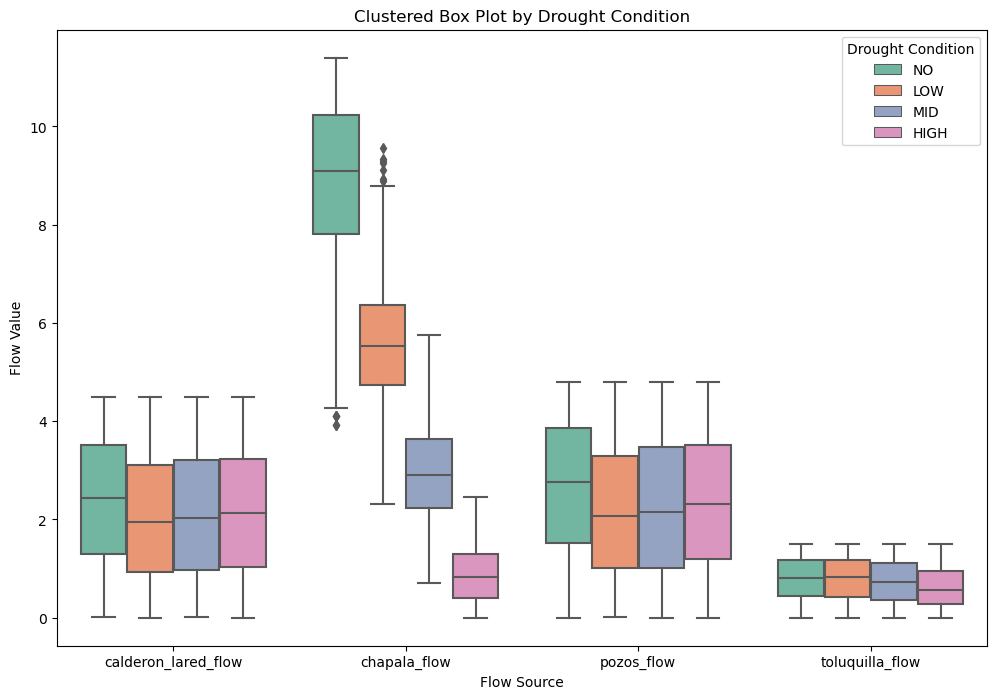

In [ ]:
# Define the columns to plot
flow_columns = ['calderon_flow', 'chapala_flow', 'pozos_flow', 'toluquilla_flow']

# Set the order for the drought_condition categories
scarcity_indicator_reference_df['drought_condition'] = pd.Categorical(
    scarcity_indicator_reference_df['drought_condition'], 
    categories=['NO', 'LOW', 'MID', 'HIGH'], 
    ordered=True
)

# Melt the dataframe for easier plotting with Seaborn
melted_df = pd.melt(scarcity_indicator_reference_df, id_vars=['drought_condition'], value_vars=flow_columns, 
                    var_name='Flow Source', value_name='Flow Value')

# Create a clustered box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=melted_df, x='Flow Source', y='Flow Value', hue='drought_condition', palette='Set2')
plt.title('Clustered Box Plot by Drought Condition')
plt.xlabel('Flow Source')
plt.ylabel('Flow Value')
plt.legend(title='Drought Condition')
plt.show()

In [ ]:

def calculate_centroids(df, drought_index_column):
    # Get unique drought states
    drought_states = df[drought_index_column].unique()
    
    # Initialize dictionary to store centroids
    centroids = {}
    
    # Loop through each drought state and calculate the centroid
    for state in drought_states:
        state_df = df[df[drought_index_column] == state]
        centroid = state_df.mean().to_dict()
        # Remove the drought index column from the centroid calculation
        centroid.pop(drought_index_column, None)
        centroids[state] = centroid
    
    return centroids

# Example usage
df = pd.read_csv("results/categorized_drought_states_1000states.csv")  # Load your dataframe
drought_index_column = 'drought_condition'  # Replace with the name of your drought index column

centroids = calculate_centroids(df, drought_index_column)
print(centroids["HIGH"])

{'Unnamed: 0': 5031.216142270861, 'calderon_lared_flow': 2.142573091591944, 'chapala_flow': 0.8892493641441167, 'pozos_flow': 2.342841549785032, 'toluquilla_flow': 0.6162222341346006, 'scenario': 350133.69357045146, 'probability': 0.9666415868673071}


C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\2095336265.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  centroid = state_df.mean().to_dict()


### 2.1 Logistic Regresion for each threshold


In [ ]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

log_reg_results = {}
dataframes = {}



for threshold in [50, 100, 128]:
    full_df = pd.read_csv(f"experiment_results\ZAs_below_{threshold} - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")
    #loading the results from the 50l/day/person 1000 scenarios with restriction optimization
    log_reg_df = full_df

    #Create a new column with False for the scenarios where there's no solution that can ensure that all ZA are above the sufficientarian threshold
    variable_of_interest = f"ZAs_below_{threshold}"
    log_reg_df["scenario_of_interest"] = log_reg_df[variable_of_interest] > 0

    log_reg_df=log_reg_df.loc[:][:][['chapala_flow', 'calderon_flow',
        'pozos_flow', 'toluquilla_flow',"scenario_of_interest"]]
    
    dataframes = {threshold:log_reg_df}

    log_reg_df["intercept"] = np.ones(np.shape(log_reg_df)[0])
    predictors = ['chapala_flow', 'calderon_flow', 'pozos_flow', 'toluquilla_flow', 'intercept']

    logit = sm.Logit(log_reg_df["scenario_of_interest"], log_reg_df[predictors])
    log_reg_results[threshold] = logit.fit()


def predict_scenario(scenario,threshold):
    # Add an intercept term
    scenario['intercept'] = 1

    # Predict the probability of the scenario being of interest
    scenario_array = np.array([scenario[col] for col in predictors])
    log_odds = np.dot(log_reg_results[threshold].params, scenario_array)
    probability = 1 / (1 + np.exp(-log_odds))
    
    return probability





Optimization terminated successfully.
         Current function value: 0.017697
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.117145
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.158112
         Iterations 9


In [ ]:
print(log_reg_results[128].summary2())

                            Results: Logit
Model:              Logit                Method:           MLE        
Dependent Variable: scenario_of_interest Pseudo R-squared: 0.769      
Date:               2024-06-12 16:35     AIC:              326.2247   
No. Observations:   1000                 BIC:              350.7635   
Df Model:           4                    Log-Likelihood:   -158.11    
Df Residuals:       995                  LL-Null:          -683.31    
Converged:          1.0000               LLR p-value:      4.2519e-226
No. Iterations:     9.0000               Scale:            1.0000     
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
chapala_flow          -1.7980   0.1437 -12.5168 0.0000 -2.0796 -1.5165
calderon_lared_flow   -0.8567   0.1319  -6.4948 0.0000 -1.1153 -0.5982
pozos_flow            -1.1654   0.

### 2.2 Testing the logistic regression

In [ ]:

new_scenario = {
    'chapala_flow': 6.9,
    'calderon_flow': 1,
    'pozos_flow': 2.3,
    'toluquilla_flow': 0.5
}

probability_threshold = 0.5
sufficientarian_thresholds = [50, 100, 128]

for threshold in sufficientarian_thresholds:
    likelihood = predict_scenario(new_scenario, threshold) 

    print(f"The likelihood that at least one ZA will fall below {threshold}l/day/person under this scenario is : {likelihood:.2f}")

for threshold in sufficientarian_thresholds:
    likelihood = predict_scenario(new_scenario, threshold)
    
    if likelihood>= probability_threshold:
        if threshold == 50: 
            print("Thus, the current drought state is considered HIGH")
            break
        elif threshold == 100: 
            print("Thus, the current drought state is considered  MID drought")
            break
        elif threshold == 128:
            print("Thus, the current drought state is considered LOW")
            break
    if threshold == 128: print("Thus, the current drought state is considered NO drought")
        

The likelihood that at least one ZA will fall below 50l/day/person under this scenario is : 0.00
The likelihood that at least one ZA will fall below 100l/day/person under this scenario is : 0.00
The likelihood that at least one ZA will fall below 142l/day/person under this scenario is : 0.76
Thus, the current drought state is considered LOW drought


C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\2582373963.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  contour_cmap = mpl.cm.get_cmap('RdBu')


Optimization terminated successfully.
         Current function value: 0.099763
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.116279
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.026533
         Iterations 14


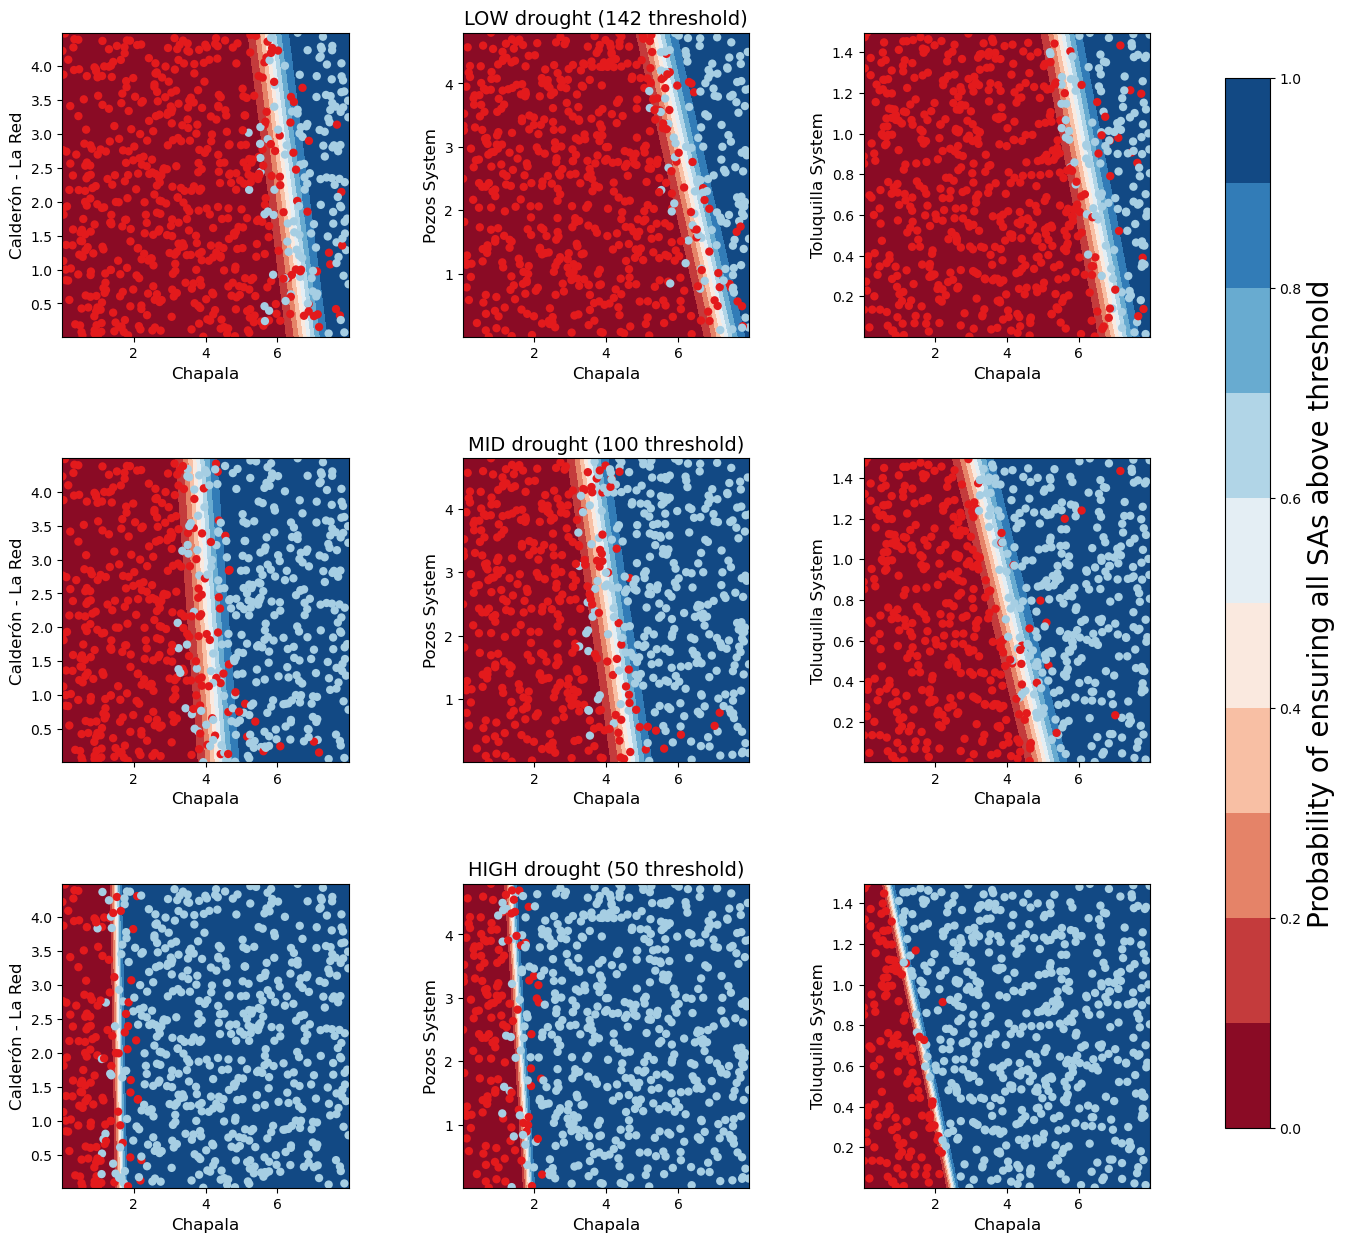

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

def load_and_prepare_data(threshold):
    full_df = pd.read_csv(f"experiment_results/ZAs_below_{threshold} - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")
    log_reg_df = full_df.loc[full_df["chapala_flow"] < 8][:]
    variable_of_interest = f"ZAs_below_{threshold}"
    log_reg_df["scenario_of_interest"] = log_reg_df[variable_of_interest] == 0
    predictors = ["chapala_flow", 'calderon_flow', 'pozos_flow', 'toluquilla_flow']
    target = 'scenario_of_interest'
    dta = log_reg_df[predictors + [target]]
    return dta, predictors, target

def fitLogit(dta, predictors):
    dta['Intercept'] = np.ones(np.shape(dta)[0])
    cols = ['Intercept'] + predictors
    logit = sm.Logit(dta['scenario_of_interest'], dta[cols])
    result = logit.fit()
    return result

def plotContourMap(ax, result, constant, dta, contour_cmap, dot_cmap, levels, xgrid, ygrid, xvar, yvar, base):
    X, Y = np.meshgrid(xgrid, ygrid)
    x = X.flatten()
    y = Y.flatten()

    if constant == 'pozos_flow':  # pozos_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, y, np.ones(len(x)) * base[2], np.ones(len(x)) * base[3]])
    elif constant == 'calderon_flow':  # calderon_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, np.ones(len(x)) * base[1], y, np.ones(len(x)) * base[3]])
    elif constant == 'toluquilla_flow':  # toluquilla_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, np.ones(len(x)) * base[1], np.ones(len(x)) * base[2], y])
    else:  # chapala_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), np.ones(len(x)) * base[0], x, y, np.ones(len(x)) * base[3]])

    z = result.predict(grid)
    Z = np.reshape(z, np.shape(X))

    contourset = ax.contourf(X, Y, Z, levels, cmap=contour_cmap)
    ax.scatter(dta[xvar].values, dta[yvar].values, c=dta['scenario_of_interest'].values, edgecolor='none', cmap=dot_cmap)
    ax.set_xlim(np.min(X), np.max(X))
    ax.set_ylim(np.min(Y), np.max(Y))
    ax.set_xlabel(xvar, fontsize=12)
    ax.set_ylabel(yvar, fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

    # Rename the axes
    ax.set_xlabel('Chapala', fontsize=12)
    if yvar == 'calderon_flow':
        ax.set_ylabel('Calderón - La Red', fontsize=12)
    elif yvar == 'pozos_flow':
        ax.set_ylabel('Pozos System', fontsize=12)
    elif yvar == 'toluquilla_flow':
        ax.set_ylabel('Toluquilla System', fontsize=12)

    return contourset

# Define color maps and levels
dot_cmap = mpl.colors.ListedColormap(np.array([[227, 26, 28], [166, 206, 227]]) / 255.0)
contour_cmap = mpl.cm.get_cmap('RdBu')
contour_levels = np.arange(0.0, 1.05, 0.1)

# Initialize the figure
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

thresholds = [128, 100, 50]
titles = ['LOW drought (128 threshold)', 'MID drought (100 threshold)', 'HIGH (50 threshold)']

for i, threshold in enumerate(thresholds):
    dta, predictors, target = load_and_prepare_data(threshold)
    result = fitLogit(dta, predictors)
    
    xgrid = np.linspace(dta[predictors[0]].min(), dta[predictors[0]].max(), 100)
    ygrid = np.linspace(dta[predictors[1]].min(), dta[predictors[1]].max(), 100)
    zgrid = np.linspace(dta[predictors[2]].min(), dta[predictors[2]].max(), 100)
    tgrid = np.linspace(dta[predictors[3]].min(), dta[predictors[3]].max(), 100)
    base = [dta[predictors[0]].mean(), dta[predictors[1]].mean(), dta[predictors[2]].mean(), dta[predictors[3]].mean()]

    plotContourMap(axes[i, 0], result, 'pozos_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, ygrid, predictors[0], predictors[1], base)
    plotContourMap(axes[i, 1], result, 'calderon_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, zgrid, predictors[0], predictors[2], base)
    contourset = plotContourMap(axes[i, 2], result, 'toluquilla_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, tgrid, predictors[0], predictors[3], base)

    axes[i, 1].set_title(titles[i], fontsize=14)

# Adjust subplot spacing and add a single colorbar for the entire figure
fig.subplots_adjust(wspace=0.4, hspace=0.4, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(contourset, cax=cbar_ax, cmap=contour_cmap)
cbar_ax.set_ylabel('Probability of ensuring all SAs above threshold', fontsize=20)

plt.show()


### 2.3 Making the Indicator Funciton

In [ ]:
def calculate_urban_drought_indicator(drought_state={'chapala_flow': 6.9,'calderon_lared_flow': 1,'pozos_flow': 2.3,'toluquilla_flow': 0.5},
                                                     probability_threshold = 0.5,
                                                     sufficientarian_thresholds = [50, 100, 128]):

    for threshold in sufficientarian_thresholds:
        likelihood = predict_scenario(drought_state, threshold)
        
        if likelihood>= probability_threshold:
            if threshold == sufficientarian_thresholds[0]: 
                drought_conditions = "HIGH"
                break
            elif threshold == sufficientarian_thresholds[1]: 
                drought_conditions = "MID"
                break
            elif threshold == sufficientarian_thresholds[2]:
                drought_conditions = "LOW"
                break
        if threshold == sufficientarian_thresholds[2]: drought_conditions = "NO"
    
    return drought_conditions, round(likelihood,2)
    

drought_index = calculate_urban_drought_indicator(new_scenario)

In [ ]:
drought_index = calculate_urban_drought_indicator(drought_state=new_scenario
)

print(drought_index)

('LOW', 0.76)


### 2.4 Validating the Indicator

To validate the indicator we will estimate the drought contitions for each drought state of the results of the three optimizations. By comparing the amount of ZAs under the threshold of the current optimization to the drought conditions estimated by the indicator we can assess how precise is the indicator. The results of each optimization are only usefull to assess the precision of their correspondant drought condition. For example, if we want to assess the capacity of the indicator to label HIGH drought conditions we will check how often it estimated that drought conditions are high for the cases where the optimization algorithm found 1 or more ZAs under 50l/day/person.

In [ ]:
scarcity_indicator_validation_df = pd.DataFrame()

for indicator in ["ZAs_below_50", "ZAs_below_100", "ZAs_below_128"]:

    validation_df = pd.read_csv(f"experiment_results\{indicator} - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")
    validation_df = validation_df.loc[:][['chapala_flow', 'calderon_flow', 'pozos_flow', 'toluquilla_flow', 'ZAs_below_50',"ZAs_below_100", "ZAs_below_128"]]
    validation_df["drought_state"] = ""
    validation_df["probability"] = ""
    for index, row in validation_df.iterrows():


        drought_state = row[['chapala_flow', 'calderon_flow', 'pozos_flow', 'toluquilla_flow']].to_dict()
        probability_threshold = 0.5
        sufficientarian_thresholds = [50, 100, 128]

        drought_indicator = calculate_urban_drought_indicator(drought_state=drought_state, probability_threshold=probability_threshold, sufficientarian_thresholds=sufficientarian_thresholds)
        
        drought_state = drought_indicator[0]
        likelihood = drought_indicator[1]

        validation_df["probability"][index] = likelihood
        validation_df["drought_state"][index]=drought_state
        validation_df["optimization"] = indicator




    scarcity_indicator_validation_df = pd.concat([scarcity_indicator_validation_df, validation_df], axis = 0)

scarcity_indicator_validation_df.to_csv("results/scarcity_validation_df.csv")



C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\2240702807.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["probability"][index] = likelihood
C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\2240702807.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["drought_state"][index]=drought_state


In [ ]:
scarcity_indicator_validation_df.head()

,chapala_flow,calderon_lared_flow,pozos_flow,toluquilla_flow,ZAs_below_50,ZAs_below_100,ZAs_below_142,drought_state,probability,optimization
0,9.073719,3.849682,4.058541,0.156112,0.0,1.0,1.0,NO,0.0,ZAs_below_50
1,8.654988,1.304894,2.469831,0.078252,0.0,0.0,1.0,NO,0.15,ZAs_below_50
2,8.433053,0.223405,4.303270,0.419695,0.0,1.0,1.0,NO,0.04,ZAs_below_50
3,8.382582,0.605412,1.098129,0.060575,0.0,1.0,2.0,LOW,0.72,ZAs_below_50
4,5.756758,1.478194,3.580713,0.544802,0.0,0.0,1.0,LOW,0.78,ZAs_below_50


In [ ]:
import pandas as pd

# Assuming the `scarcity_indicator_validation_df` has been created and populated

def calculate_summary(df):
    summary = {
        'HIGH drought': {
            'True positive': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] > 0) & (df['drought_state'] == 'HIGH')).sum(),
            'True negative': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] == 0) & (df['drought_state'].isin(['MID', 'LOW', 'NO']))).sum(),
            'False positive': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] == 0) & (df['drought_state'] == 'HIGH')).sum(),
            'False negative': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] > 0) & (df['drought_state'].isin(['MID', 'LOW', 'NO']))).sum(),
        },
        'MID drought': {
            'True positive': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] > 0) & (df['drought_state'] == 'MID')).sum(),
            'True negative': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] == 0) & (df['drought_state'].isin(['HIGH', 'LOW', 'NO']))).sum(),
            'False positive': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] == 0) & (df['drought_state'] == 'MID')).sum(),
            'False negative': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] > 0) & (df['drought_state'].isin(['LOW', 'NO']))).sum(),
        },
        'LOW drought': {
            'True positive': ((df['optimization'] == 'ZAs_below_128') & (df['ZAs_below_128'] > 0) & (df['drought_state'] == 'LOW')).sum(),
            'True negative': ((df['optimization'] == 'ZAs_below_128') & (df['ZAs_below_128'] == 0) & (df['drought_state'] == 'NO')).sum(),
            'False positive': ((df['optimization'] == 'ZAs_below_128') & (df['ZAs_below_128'] == 0) & (df['drought_state'] == 'LOW')).sum(),
            'False negative': ((df['optimization'] == 'ZAs_below_128') & (df['ZAs_below_128'] > 0) & (df['drought_state'].isin(['NO']))).sum(),
        },
    }

    summary_df = pd.DataFrame(summary)
    summary_df.loc['Total'] = summary_df.sum()
    
    return summary_df

def calculate_ratios(summary_df):
    ratios_df = summary_df.div(summary_df.loc['Total'])
    return ratios_df

# Load your existing validation dataframe
scarcity_indicator_validation_df = pd.read_csv("results/scarcity_validation_df.csv")

# Calculate the summary
summary_df = calculate_summary(scarcity_indicator_validation_df)
ratios_df = calculate_ratios(summary_df)

# Combine both summary and ratios into one DataFrame for better readability
combined_df = summary_df.append(ratios_df.rename(lambda x: x + ' ratio'))

# Output the combined DataFrame to clipboard and print
combined_df.to_clipboard()
print(combined_df)



                      HIGH drought  MID drought  LOW drought
True positive              132.000   207.000000   179.000000
True negative              863.000   627.000000   395.000000
False positive               3.000    18.000000    35.000000
False negative               2.000    13.000000    31.000000
Total                     1000.000   865.000000   640.000000
True positive ratio          0.132     0.239306     0.279687
True negative ratio          0.863     0.724855     0.617188
False positive ratio         0.003     0.020809     0.054688
False negative ratio         0.002     0.015029     0.048438
Total ratio                  1.000     1.000000     1.000000


### Creating a DataFrame with the categorized drought states for reference

In [ ]:
scarcity_indicator_reference_df = pd.read_csv("data\drought_scenarios_10000 - seed1.csv")
scarcity_indicator_reference_df["drought_condition"] = ""
scarcity_indicator_reference_df["probability"] = ""

for index, row in scarcity_indicator_reference_df.iterrows():

    drought_state = row[['chapala_flow', 'calderon_flow', 'pozos_flow', 'toluquilla_flow']].to_dict()
    probability_threshold = 0.5
    sufficientarian_thresholds = [50, 100, 128]

    drought_indicator = calculate_urban_drought_indicator(drought_state=drought_state, probability_threshold=probability_threshold, sufficientarian_thresholds=sufficientarian_thresholds)
    
    drought_state = drought_indicator[0]
    likelihood = drought_indicator[1]

    scarcity_indicator_reference_df["probability"][index] = likelihood
    scarcity_indicator_reference_df["drought_condition"][index] = drought_state

scarcity_indicator_reference_df.to_csv("results/categorized_drought_states_10000states.csv")
scarcity_indicator_reference_df.head()

C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\1523688332.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scarcity_indicator_reference_df["probability"][index] = likelihood
C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\1523688332.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scarcity_indicator_reference_df["drought_condition"][index] = drought_state


,calderon_lared_flow,chapala_flow,pozos_flow,toluquilla_flow,scenario,policy,model,drought_condition,probability
0,3.849682,9.073719,4.058541,0.156112,343660,None,AMGmodel,NO,0.0
1,1.304894,8.654988,2.469831,0.078252,387278,None,AMGmodel,NO,0.15
2,0.223405,8.433053,4.303270,0.419695,314317,None,AMGmodel,NO,0.04
3,0.605412,8.382582,1.098129,0.060575,381932,None,AMGmodel,LOW,0.72
4,1.478194,5.756758,3.580713,0.544802,395321,None,AMGmodel,LOW,0.78


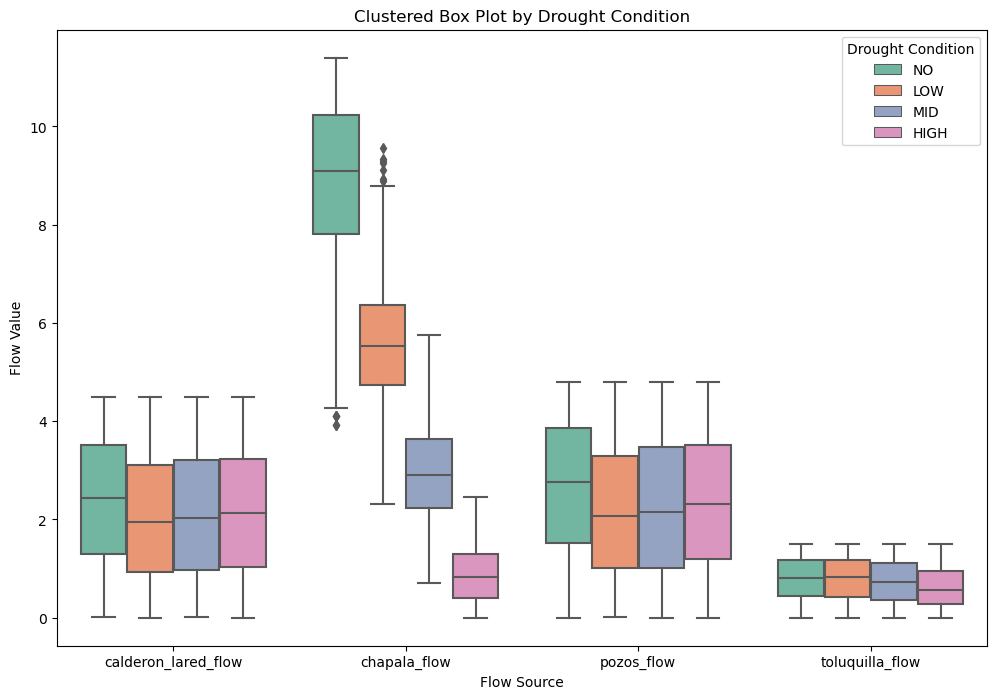

In [ ]:
# Define the columns to plot
flow_columns = ['calderon_flow', 'chapala_flow', 'pozos_flow', 'toluquilla_flow']

# Set the order for the drought_condition categories
scarcity_indicator_reference_df['drought_condition'] = pd.Categorical(
    scarcity_indicator_reference_df['drought_condition'], 
    categories=['NO', 'LOW', 'MID', 'HIGH'], 
    ordered=True
)

# Melt the dataframe for easier plotting with Seaborn
melted_df = pd.melt(scarcity_indicator_reference_df, id_vars=['drought_condition'], value_vars=flow_columns, 
                    var_name='Flow Source', value_name='Flow Value')

# Create a clustered box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=melted_df, x='Flow Source', y='Flow Value', hue='drought_condition', palette='Set2')
plt.title('Clustered Box Plot by Drought Condition')
plt.xlabel('Flow Source')
plt.ylabel('Flow Value')
plt.legend(title='Drought Condition')
plt.show()

In [ ]:

def calculate_centroids(df, drought_index_column):
    # Get unique drought states
    drought_states = df[drought_index_column].unique()
    
    # Initialize dictionary to store centroids
    centroids = {}
    
    # Loop through each drought state and calculate the centroid
    for state in drought_states:
        state_df = df[df[drought_index_column] == state]
        centroid = state_df.mean().to_dict()
        # Remove the drought index column from the centroid calculation
        centroid.pop(drought_index_column, None)
        centroids[state] = centroid
    
    return centroids

# Example usage
df = pd.read_csv("results/categorized_drought_states_1000states.csv")  # Load your dataframe
drought_index_column = 'drought_condition'  # Replace with the name of your drought index column

centroids = calculate_centroids(df, drought_index_column)
print(centroids["HIGH"])

{'Unnamed: 0': 5031.216142270861, 'calderon_lared_flow': 2.142573091591944, 'chapala_flow': 0.8892493641441167, 'pozos_flow': 2.342841549785032, 'toluquilla_flow': 0.6162222341346006, 'scenario': 350133.69357045146, 'probability': 0.9666415868673071}


C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\2095336265.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  centroid = state_df.mean().to_dict()
